### Predicting HDB Prices with eXtreme Gradient Boosting - XGBoost

Having collected the data, wrangled it together, done exploratory data analysis, we will now begin to model the data to predict HDB prices. 

In this notebook, we will be using an XGBoost Regressor for prediction - a highly efficient and scalable implementation of the gradient boosting algorithm. 

#### Brief Recap on XGBoost
- **Ensemble Learning Method** 
  -  It makes predictions by combining many simple models (called decision trees).
- **Gradient Boosting Framework** 
  - Builds trees sequentially - new simple model focuses on fixing errors made by the previous ones.
- **Handling of Various Types of Data** 
  - Effective for both categorical and numerical data.
  - Not so necessary to standardize or normalize numeric data
    - Because it uses decision trees, which split nodes based on the value of a feature, standard scaling or min-max normalization is not required for XGBoost to perform effectively.
    - If you want to know which features are most important in your model, having them all on the same scale can make this clearer.
    - Standardization or normalization does not inherently handle outliers, but it can make the model less sensitive to them. However, decision tree-based methods like XGBoost are generally quite robust to outliers.
    - For some datasets, especially those with features varying in scales and units, having all features on a similar scale can make it easier to adjust the model settings for better performance.
  - Always recommended to experiment with both standardized and non-standardized data to see which approach yields better results
- **Regularization** 
  - Includes L1 (Lasso) and L2 (Ridge) regularization to prevent overfitting
  - Generalizes well, has built-in checks to avoid making the model too complex.
- **Missing Values** 
  - Can handle data even if some is missing.
- **Tree Pruning** 
  - Uses a depth-first approach, allowing for more intuitive pruning of trees.
  - Stops to build trees when they're not useful anymore.
- **Cross-validation Capability** 
  - Built-in cross-validation at each iteration
  - Using that information to improve model accuracy and robustness.
- **Speed and Performance** 
  - Optimized for speed and performance
  - Can handle large datasets
  - Scales well on multi-core CPUs.
- **Hyperparameter Tuning** 
  - Offers a variety of hyperparameters for fine-tuning models to to get better predictions.



#### Load Libraries

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Train Test Split
from sklearn.model_selection import train_test_split, cross_validate

# Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# Modelling
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Model Evaluation
from sklearn.metrics import mean_absolute_error, r2_score
import scipy.stats as stats

#### Load data into DataFrame and Remove Unwanted Columns

In [2]:
# Make file path variable so that all we need is to change this if we move notebook location
file_path = '../data/processed/final_HDB_for_model.parquet.gzip'

# Read data into csv
df = pd.read_parquet(file_path)

# Check to see if it loaded correctly
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890376 entries, 0 to 890375
Data columns (total 27 columns):
 #   Column                                                                         Non-Null Count   Dtype         
---  ------                                                                         --------------   -----         
 0   town                                                                           890376 non-null  object        
 1   flat_type                                                                      890376 non-null  object        
 2   block                                                                          890376 non-null  object        
 3   street_name                                                                    890376 non-null  object        
 4   storey_range                                                                   890376 non-null  object        
 5   floor_area_sqm                                                          

In [3]:
# Put all columns to be deleted into a list
drop_cols = ['block', 'street_name','address','sold_year_month']

# Drop columns
df = df.drop(columns=drop_cols)

#### Creating a Pipeline 
Pipelines in machine learning are useful because they streamline the entire process of preparing data and building models. Most importantly, they make things repeatable without human error! 

In [4]:
# Create lists of the categorical and numerical columns allowing them to be treated differently
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns


In [16]:
# Create instances of OneHotEncoder
cat_transformer = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=True)

# Create a pipeline to apply transformation
prepoc = make_column_transformer(
    (cat_transformer, cat_cols),
    remainder='passthrough'
)

# View Pipeline
prepoc

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 Index(['town', 'flat_type', 'storey_range', 'flat_model', 'most_closest_mrt'], dtype='object'))])

#### Train Test Split the Data 

In [17]:
# Select target column
target_col = 'resale_price'

# Ready X and y
X = df.loc[:, ~df.columns.isin([target_col])]
y = df[target_col]


In [18]:
# Split the data, 80-20 split with a random state included for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 54)


In [24]:
# Create final pipeline with model
pipe = make_pipeline(prepoc, XGBRegressor())

# View Pipeline
pipe


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['town', 'flat_type', 'storey_range', 'flat_model', 'most_closest_mrt'], dtype='object'))])),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=Non...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

#### Train and Fit Baseline XGBoost Model

In [25]:
# Fit model
pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['town', 'flat_type', 'storey_range', 'flat_model', 'most_closest_mrt'], dtype='object'))])),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=Non...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [ ]:
pipe.steps[1][1]

In [26]:
# R2 score on training set
r2_baseline_train = pipe.score(X_train, y_train)

# MAE for training
y_pred = pipe.predict(X_train)
mae_baseline_train = mean_absolute_error(y_train, y_pred)

# Print scores to assess
print("Training r2 score =", round(r2_baseline_train, 4))
print("Training MAE score =", round(mae_baseline_train, 2))


Training r2 score = 0.9785
Training MAE score = 17260.73


In [27]:
# R2 score on testing set
r2_baseline_test = pipe.score(X_test, y_test)

# MAE for testing
y_pred = pipe.predict(X_test)
mae_baseline_test = mean_absolute_error(y_test, y_pred)

# Print scores to assess
print("Test r2 score =", round(r2_baseline_test, 4))
print("Test MAE score =", round(mae_baseline_test, 2))


Test r2 score = 0.9774
Test MAE score = 17535.12


#### Save Baseline Model

In [16]:
# Saving Baseline model
# with open('../models/final_XGBoost_231204.pkl', 'wb') as file:
#     pickle.dump(pipe, file)


#### Improving on the Baseline Score with Hyperparameter Tuning 
- To find the best parameters for XGBoost we will use GridSearch 
- For this we will not be using the pipeline
- Will need to manually create processed variables

In [19]:
# Process X & y with preprocessing pipeline
X_train_processed = prepoc.fit_transform(X_train)
X_test_processed = prepoc.transform(X_test)


In [22]:
# Instantiate the model
xgb_reg = XGBRegressor()

# make grid to search
param_grid = {
    'n_estimators': [75, 100, 125],
    'learning_rate': [0.4, 0.3, 0.2],
    'max_depth': [5, 6, 7],
    'min_child_weight': [0.5, 1, 2],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.75, 1]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_processed, y_train)

# Best parameters found
print(grid_search.best_params_)

Fitting 3 folds for each of 486 candidates, totalling 1458 fits


[CV] END gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0.5, n_estimators=75, subsample=0.75; total time=   5.3s
[CV] END gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0.5, n_estimators=75, subsample=1; total time=   5.5s
[CV] END gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0.5, n_estimators=75, subsample=0.75; total time=   5.6s
[CV] END gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0.5, n_estimators=75, subsample=1; total time=   5.6s
[CV] END gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0.5, n_estimators=75, subsample=1; total time=   5.7s
[CV] END gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0.5, n_estimators=75, subsample=0.75; total time=   5.7s
[CV] END gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0.5, n_estimators=100, subsample=0.75; total time=   6.9s
[CV] END gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0.5, n_estimators=100, subsample=0.75; total time=   7.1s
[CV] END gamma=

In [27]:
grid_search.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.4, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=0.5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=125, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [30]:
# MAE for training
y_pred = grid_search.best_estimator_.predict(X_train_processed)
mae_baseline_train = mean_absolute_error(y_train, y_pred)

# Print scores to assess
print("Training MAE score =", round(mae_baseline_train, 2))

Training MAE score = 15234.58


In [31]:
# R2 score on testing set
r2_baseline_test = grid_search.best_estimator_.score(X_test_processed, y_test)

# MAE for testing
y_pred = grid_search.best_estimator_.predict(X_test_processed)
mae_baseline_test = mean_absolute_error(y_test, y_pred)

# Print scores to assess
print("Test r2 score =", round(r2_baseline_test, 4))
print("Test MAE score =", round(mae_baseline_test, 2))

Test r2 score = 0.9814
Test MAE score = 15870.06


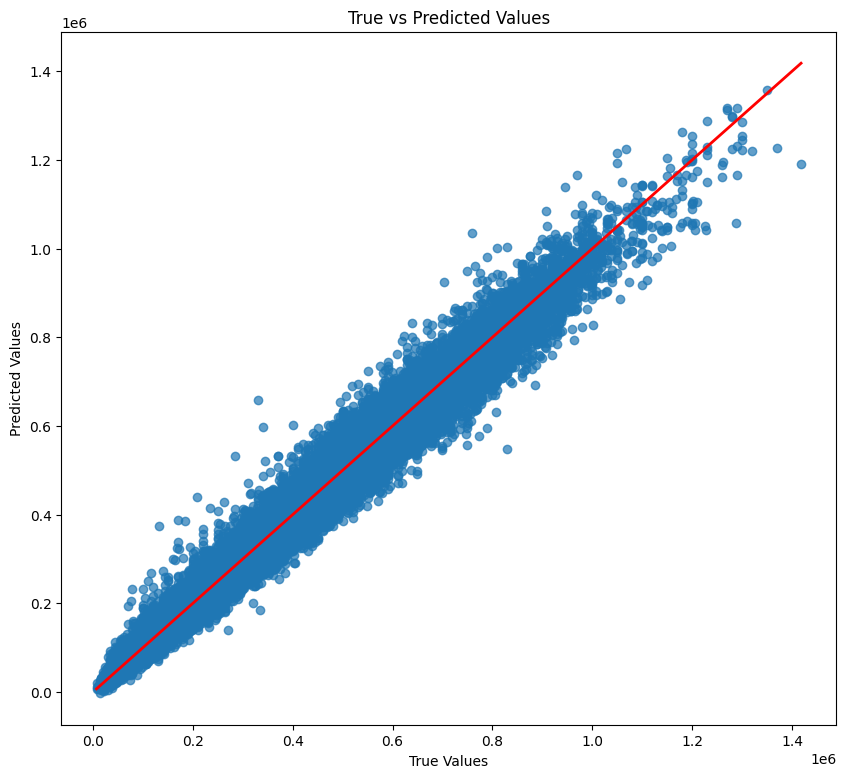

In [32]:
# plot model performance
plt.figure(figsize=(10, 9))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()

**comments**
- The concentration of points is closer to the red line in the lower value range and starts to disperse as the value increases.
- There is a noticeable pattern where the predicted values tend to be lower than the true values as the magnitude increases, especially beyond approximately 1 million, suggesting a potential underestimation by the model for higher true values.




